## Install dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgetsb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## Connect to Google Disk

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Make needed imports

In [ ]:
import numpy as np
from PIL import Image
import cv2
import os

In [ ]:
# Bringing in tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Bringing in matplotlib for viz stuff
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Load and convert prepaired images

In [ ]:
def split(array, nrows, ncols):
    """Split a matrix into sub-matrices."""

    r, h = array.shape
    return (array.reshape(h//nrows, nrows, -1, ncols)
                 .swapaxes(1, 2)
                 .reshape(-1, nrows, ncols))

In [ ]:
IMG_DIR = "/content/drive/MyDrive/data/gan/128_images"
images128X128 = np.empty([0, 128, 128])
imgs = np.empty([0, 64, 64])

for img in os.listdir(IMG_DIR):
    img_array = cv2.imread(os.path.join(IMG_DIR, img), cv2.IMREAD_GRAYSCALE)

    S = split(img_array, 256, 256)
    #ST = split(img_array.T, 256, 256)
    #SST = np.append(S, ST, axis=0)
    #FSST = np.append([np.fliplr(i) for i in SST], SST, axis=0)

    #imgs = np.append(FSST, imgs, axis=0)
    for fsst in S:
      images128X128 = np.append(split(fsst, 128, 128), images128X128, axis=0)
    
      for i in images128X128:
        imgs = np.append(split(i, 64, 64), imgs, axis=0)
      
      images128X128 = np.empty([0, 128, 128])
  
imgs.shape

(8192, 64, 64)

In [ ]:
imgs.shape

(8192, 64, 64)

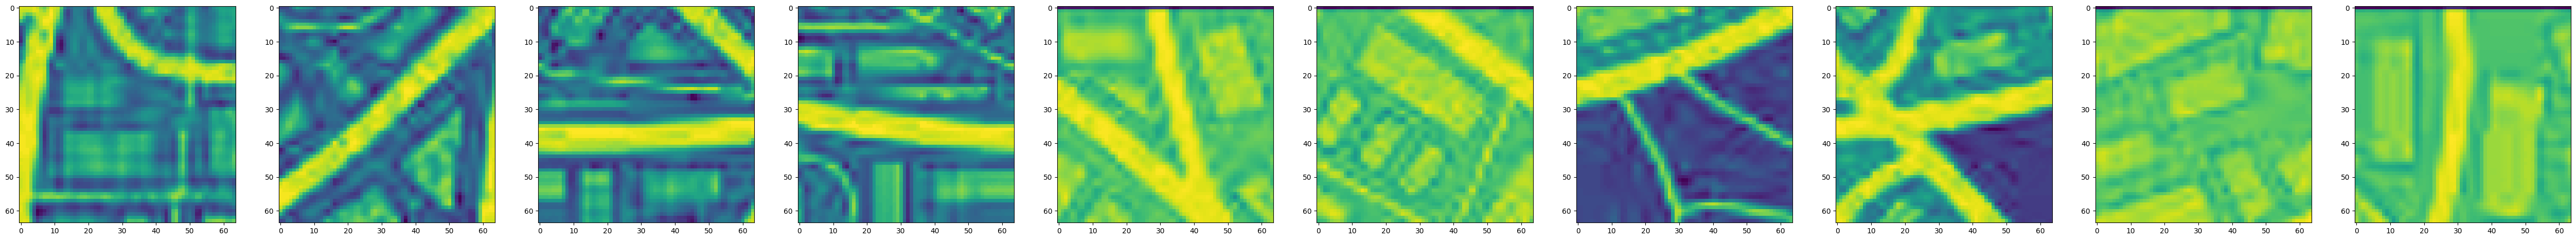

In [ ]:
# Do some data transformation
import numpy as np

# Setup the subplot formatting 
idx = 0
fig, ax = plt.subplots(ncols=10, figsize=(64, 64))
# Loop four times and get images 
for i in range(10):
  idx = idx + 1
  ax[i].imshow(imgs[50 - idx])

fig.show()

## Prepare images

In [ ]:
from tensorflow.python.data.ops.dataset_ops import PrefetchDataset
from  torch.utils.data import DataLoader

b = tf.data.Dataset.from_tensor_slices(([i.reshape(64,64,1) / 255 for i in imgs]))
# Cache the dataset for that batch 
b = b.cache()
# Shuffle it up 
b = b.shuffle(600)
# Batch into 128 images per sample
b = b.batch(128)
# Reduces the likelihood of bottlenecking 
b = b.prefetch(8)
b

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float64, name=None)>

# Build Neural Network

In [ ]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [ ]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 8x8x128
    # Beginnings of a generated image
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(64, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(64, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling block 3
    model.add(UpSampling2D())
    model.add(Conv2D(64, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(64, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(64, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 3
    model.add(Conv2D(64, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              1056768   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8192)              0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        204864    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                        

1/1 [==============================] - 1s 657ms/step


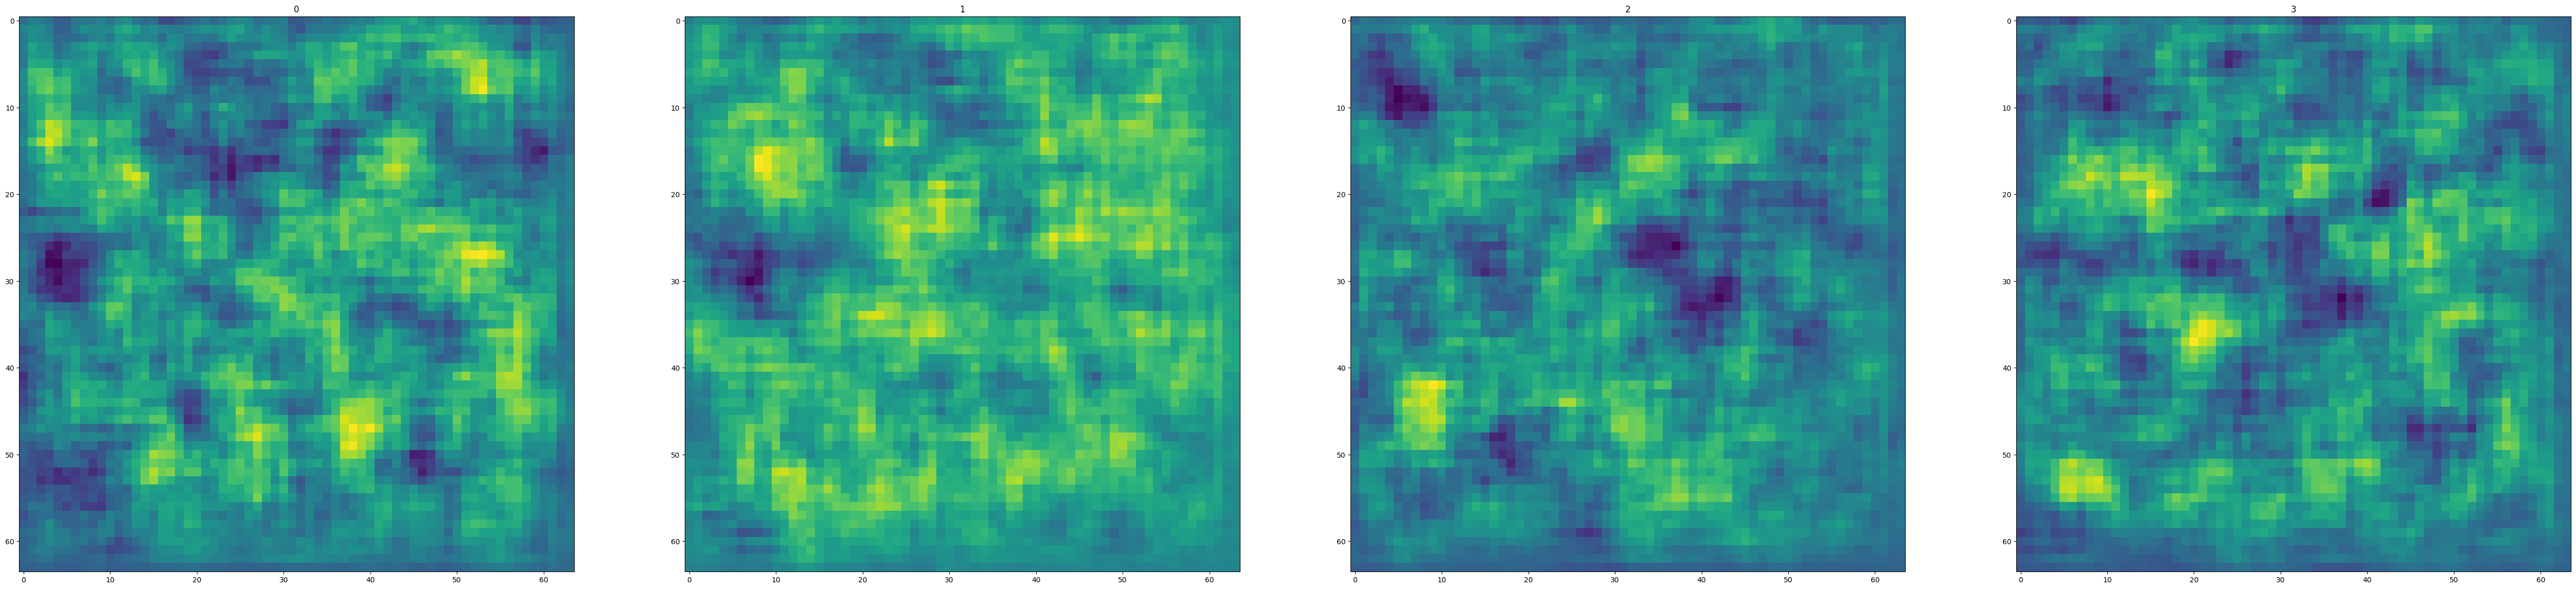

In [ ]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(64,64))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

## Build Discriminator

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(68, 5, input_shape = (64,64,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(68 * 2, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(68 * 4, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 60, 60, 68)        1768      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 60, 60, 68)        0         
                                                                 
 dropout (Dropout)           (None, 60, 60, 68)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 136)       231336    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 56, 56, 136)       0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 136)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 272)      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 241ms/step


In [ ]:
img.shape

(4, 64, 64, 1)

In [ ]:
discriminator.predict(img)

1/1 [==============================] - 1s 517ms/step


array([[0.49285227],
       [0.49286273],
       [0.4929572 ],
       [0.4927988 ]], dtype=float32)

# Construct Training Loop

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [ ]:
class MapGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
# Create instance of subclassed model
mapgan = MapGAN(generator, discriminator)

In [ ]:
# Compile the model
mapgan.compile(g_opt, d_opt, g_loss, d_loss)

## Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            if epoch % 2 == 0:
              img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

## Train

In [ ]:
# Recommend 2000 epochs
hist = mapgan.fit(b, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
35/64 [===============>..............] - ETA: 1:37:38 - d_loss: 0.6944 - g_loss: 0.7744

## Review Performance

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# Test Out the Generator

In [ ]:
# Load previously trained model if required
# generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

## Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')